In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


In [2]:
# vairables initialization
BATCH_SIZE = 100
LR = 1e-3
EPOCHS = 30

In [3]:
# data loading

transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(root = './data', train=True, transform=transform , download=True)
test_dataset = datasets.MNIST(root = './data', train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f"Data loading done\nTrain data size = {len(train_dataset)}\nTest data size = {len(test_dataset)}")
print(f"Shape of data = {train_dataset[0][0].shape}") # the dataset is (image_vecetor, label)


Data loading done
Train data size = 60000
Test data size = 10000
Shape of data = torch.Size([1, 28, 28])


In [4]:
# Model architecture

class VAE(nn.Module) :
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20) :
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim) # mean
        self.fc22 = nn.Linear(hidden_dim, latent_dim) # log(variance)
        
        # decoder part
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)
        
    def encode(self, x) :
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)
    
    def reparameterize(self, mu, logvar) :
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z) :
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))
    
    def forward(self, x) :
        x = x.view(-1, 784)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
        

In [5]:
# initialization and training

model = VAE()
optimizer = optim.Adam(model.parameters(), lr=LR)

def BCE_loss_function(recon_x, x) :
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum') 
    return BCE

def KLD_loss_function(mu, logvar) :
    KLD = -0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp())
    return KLD

def loss_function(recon_x, x, mu, logvar) :
    BCE = BCE_loss_function(recon_x, x)
    KLD = KLD_loss_function(mu, logvar)
    return BCE + KLD

print("Model initialized")

Model initialized


In [11]:
# starting training

model.train()

train_KLD_losses = []
train_BCE_losses = []

print("Training started -")

for epoch in range(EPOCHS) :
    overall_KLD_loss = 0
    overall_BCE_loss = 0
    
    for batch_idx, (x, _) in enumerate(train_loader) :
        optimizer.zero_grad()
        recon_x, mu, logvar = model.forward(x)
        loss = loss_function(recon_x, x, mu, logvar)
        loss.backward()
        optimizer.step()
        overall_KLD_loss += KLD_loss_function(mu, logvar).item()
        overall_BCE_loss += BCE_loss_function(recon_x, x).item()
    
    average_BCE_loss = overall_BCE_loss/len(train_dataset)
    average_KLD_loss = overall_KLD_loss/len(train_dataset)
    train_BCE_losses.append(average_BCE_loss)
    train_KLD_losses.append(average_KLD_loss)
    print(f"epoch = {epoch + 1} \n Average BCE loss = {average_BCE_loss}\tAverage KLD loss = {average_KLD_loss}")
    

Training started -
epoch = 1 
 Average BCE loss = 77.23972596842448	Average KLD loss = 25.34889258626302
epoch = 2 
 Average BCE loss = 77.21407303059895	Average KLD loss = 25.35382638346354
epoch = 3 
 Average BCE loss = 77.14519069824219	Average KLD loss = 25.351395703125
epoch = 4 
 Average BCE loss = 77.06240830078124	Average KLD loss = 25.33536121419271
epoch = 5 
 Average BCE loss = 77.01833595377605	Average KLD loss = 25.31905069173177
epoch = 6 
 Average BCE loss = 76.95712736816407	Average KLD loss = 25.32313952636719
epoch = 7 
 Average BCE loss = 76.90260028483073	Average KLD loss = 25.336630969238282
epoch = 8 
 Average BCE loss = 76.86458393554688	Average KLD loss = 25.33665547688802
epoch = 9 
 Average BCE loss = 76.81397449544271	Average KLD loss = 25.307048750813802
epoch = 10 
 Average BCE loss = 76.74829812011718	Average KLD loss = 25.316930729166668
epoch = 11 
 Average BCE loss = 76.68977950846354	Average KLD loss = 25.321692887369792
epoch = 12 
 Average BCE loss =

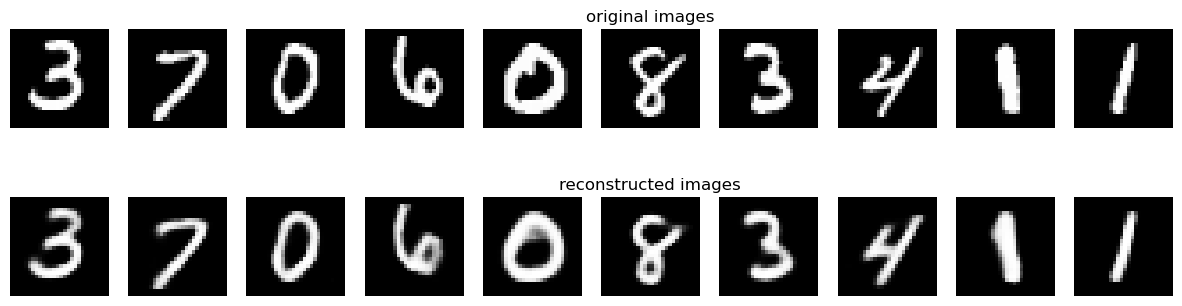

In [22]:
# evaluation of the model now
import matplotlib.pyplot as plt

model.eval()

with torch.no_grad() :
    data, _ = next(iter(test_loader))
    recon_batch, mu, logvar = model.forward(data)

fig, axes = plt.subplots(2, 10, figsize=(15, 4)) 

for i in range(10) :
    axes[0, i].imshow(data[i].view(28, 28), cmap="gray")
    axes[0, i].axis("off")
    if i == 5: axes[0, i].set_title("original images")
    axes[1, i].imshow(recon_batch[i].view(28, 28), cmap="gray")
    axes[1, i].axis("off")
    if i == 5: axes[1, i].set_title("reconstructed images")

plt.show()

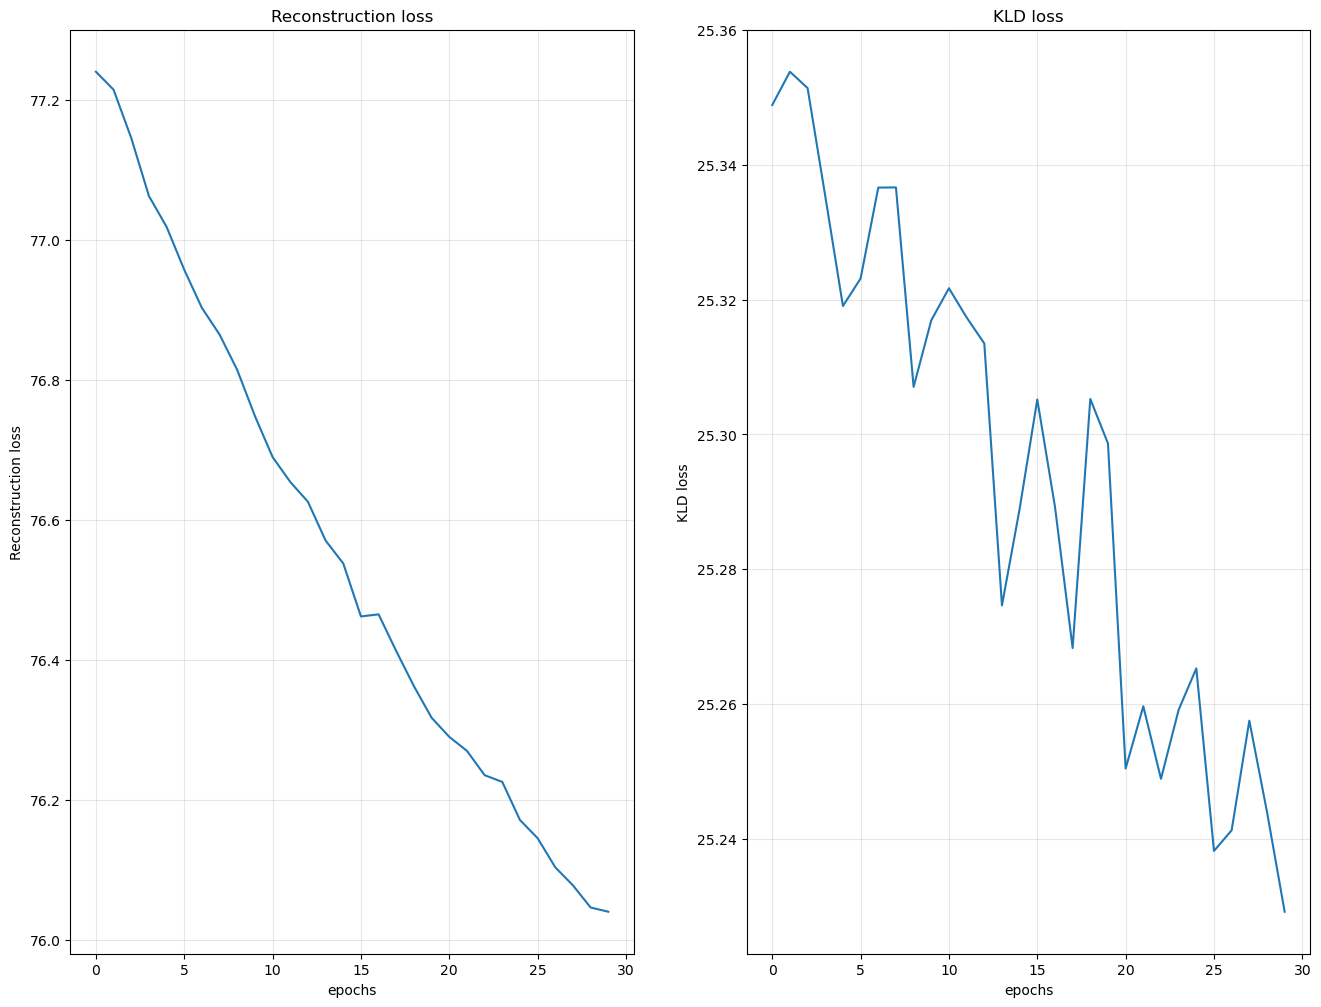

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(16, 12))

axes[0].plot(train_BCE_losses)
axes[0].set_xlabel("epochs")
axes[0].set_ylabel("Reconstruction loss")
axes[0].set_title("Reconstruction loss")
axes[0].grid(True, alpha=0.3)

axes[1].plot(train_KLD_losses)
axes[1].set_xlabel("epochs")
axes[1].set_ylabel("KLD loss")
axes[1].set_title("KLD loss")
axes[1].grid(True, alpha=0.3)

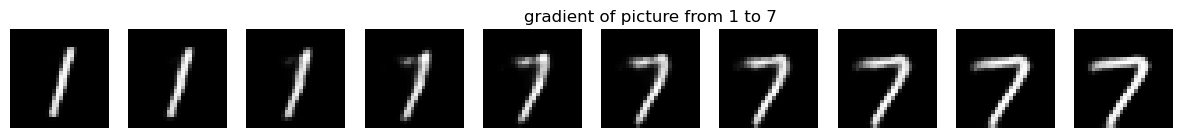

In [27]:
first_found = False
second_found = False

FIRST_NUMBER = 7
SECOND_NUMBER = 1

with torch.no_grad() :
    data, label = next(iter(test_loader))
    recon_batch, mu, logvar = model.forward(data)

first_data = None
second_data = None

i = 0
while(not (first_found and second_found)):
    if label[i] == FIRST_NUMBER :
        first_data = data[i]
        first_found = True
    
    if label[i] == SECOND_NUMBER :
        second_data = data[i]
        second_found = True
    
    i += 1

first_mu, first_logvar = model.encode(first_data.reshape(1, 784))
second_mu, second_logvar = model.encode(second_data.reshape(1, 784))

gradient = []

for i in range(10) :
    gradient.append(model.decode(first_mu*(i/10) + second_mu*(1 - i/10)))

fig, axes = plt.subplots(1, 10, figsize=(15, 4))
for i in range(10) :
    axes[i].imshow((gradient[i].detach().numpy()).reshape(28, 28), cmap="gray")
    axes[i].axis("off")
    if i == 5: axes[i].set_title(f"gradient of picture from {SECOND_NUMBER} to {FIRST_NUMBER}")